In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/iris/Iris.csv
/kaggle/input/iris/database.sqlite


In [2]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# Make NumPy printouts easier to read.
np.set_printoptions(precision=3, suppress=True)

In [3]:
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.metrics import mean_absolute_error

In [4]:
dataset = pd.read_csv("../input/iris/Iris.csv")
dataset[:4]

,Id,SepalLengthCm,SepalWidthCm,PetalLengthCm,PetalWidthCm,Species
0,1,5.1,3.5,1.4,0.2,Iris-setosa
1,2,4.9,3.0,1.4,0.2,Iris-setosa
2,3,4.7,3.2,1.3,0.2,Iris-setosa
3,4,4.6,3.1,1.5,0.2,Iris-setosa


In [5]:
train_dataset = dataset.sample(frac=0.8, random_state=0)
test_dataset = dataset.drop(train_dataset.index)

In [6]:
train_features = train_dataset.copy()
test_features = test_dataset.copy()

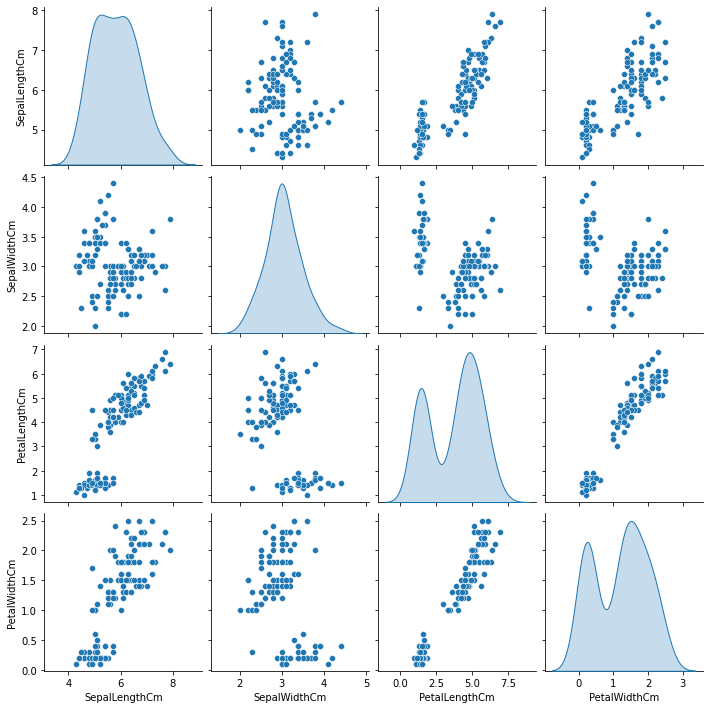

In [7]:
sns.pairplot(train_dataset[['SepalLengthCm', 'SepalWidthCm', 'PetalLengthCm', 'PetalWidthCm']], diag_kind='kde');

In [8]:
train_dataset.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Id,120.0,74.975000,43.966080,1.0,37.5,74.50,112.25,150.0
SepalLengthCm,120.0,5.823333,0.828660,4.3,5.1,5.75,6.40,7.9
SepalWidthCm,120.0,3.050833,0.438292,2.0,2.8,3.00,3.30,4.4
PetalLengthCm,120.0,3.752500,1.753075,1.0,1.6,4.40,5.10,6.9
PetalWidthCm,120.0,1.200000,0.755818,0.1,0.3,1.35,1.80,2.5


In [9]:
train_dataset.describe().transpose()[['mean', 'std']]

,mean,std
Id,74.975000,43.966080
SepalLengthCm,5.823333,0.828660
SepalWidthCm,3.050833,0.438292
PetalLengthCm,3.752500,1.753075
PetalWidthCm,1.200000,0.755818


The Normalization layer


The tf.keras.layers.Normalization is a clean and simple way to add feature normalization into your model.

The first step is to create the layer:

In [10]:
normalizer = tf.keras.layers.Normalization(axis=-1)

In [11]:
SepalLengthCm = np.array(train_features['SepalLengthCm'])

SepalLengthCm_normalizer = layers.Normalization(input_shape=[1,], axis=None)
SepalLengthCm_normalizer.adapt(SepalLengthCm)

2022-02-23 14:28:11.136024: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.
2022-02-23 14:28:11.251545: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Build the Keras Sequential model

In [12]:
SepalLengthCm_model = tf.keras.Sequential([SepalLengthCm_normalizer,
                                           layers.Dense(units=1)])

SepalLengthCm_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
normalization_1 (Normalizati (None, 1)                 3         
_________________________________________________________________
dense (Dense)                (None, 1)                 2         
Total params: 5
Trainable params: 2
Non-trainable params: 3
_________________________________________________________________


Run the untrained model on the first 10 'SepalLengthCm' values. The output won't be good, but notice that it has the expected shape of (10, 1)

In [13]:
SepalLengthCm_model.predict(SepalLengthCm[:10])

array([[ 0.027],
       [-0.205],
       [ 0.376],
       [-1.716],
       [ 0.957],
       [-0.554],
       [ 0.957],
       [-1.019],
       [-1.135],
       [-0.322]], dtype=float32)

In [14]:
train_labels = train_features.pop('PetalWidthCm')
test_labels = test_features.pop('PetalWidthCm')

In [15]:
SepalLengthCm_model.compile(optimizer=tf.optimizers.Adam(learning_rate=0.1),
                         loss='mean_absolute_error')


history = SepalLengthCm_model.fit(
    train_features['SepalLengthCm'],
    train_labels,
    epochs=100,
    # Suppress logging.
    verbose=0,
    # Calculate validation results on 20% of the training data.
    validation_split = 0.2)

In [16]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,loss,val_loss,epoch
95,0.337494,0.453229,95
96,0.337173,0.459120,96
97,0.337540,0.462176,97
98,0.338170,0.454669,98
99,0.338159,0.449072,99


In [17]:
def plot_loss(history):
    plt.plot(history.history['loss'], label='loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.ylim([0, 10])
    plt.xlabel('Epoch')
    plt.ylabel('Error [MPG]')
    plt.legend()
    plt.grid(True)
    

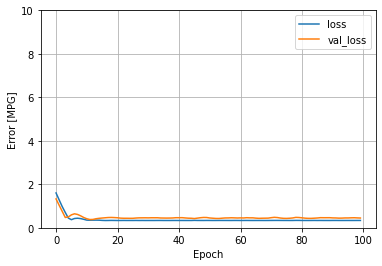

In [18]:
plot_loss(history)

In [19]:
x = tf.linspace(0.0, 250, 251)
y = SepalLengthCm_model.predict(x)

In [20]:
def plot_horsepower(x, y):
    plt.scatter(train_features['SepalLengthCm'], train_labels, label='SepalWidthCm')
    plt.plot(x, y, color='k', label='Predictions')
    plt.xlabel('SepalLengthCm')
    plt.ylabel('PetalLengthCm')
    plt.legend()

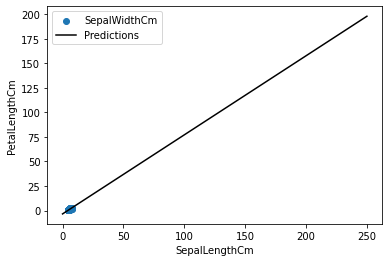

In [21]:
plot_horsepower(x, y)